In [151]:
using AngularPowerSpectra
using Healpix
using PyCall, PyPlot
using Statistics
PyPlot.svg(true)
using CSV, DataFrames, LinearAlgebra
using BenchmarkTools
using JLD2
hp = pyimport("healpy")
nmt = pyimport("pymaster")

nside = 256
npix = hp.nside2npix(nside)
Ω_p = 4π / npix
lmax = 3nside

mask1 = readMapFromFITS("data/mask1.fits", 1, Float64)
mask2 = readMapFromFITS("data/mask2.fits", 1, Float64)
freq1 = "143"
freq2 = "143"

Bl1 = CSV.read("data/beam1.csv", DataFrame).Bl
Bl2 = CSV.read("data/beam2.csv", DataFrame).Bl
beam1 = SpectralVector(Bl1 .* hp.pixwin(nside))
beam2 = SpectralVector(Bl2 .* hp.pixwin(nside))

theory = CSV.read("data/theory.csv", DataFrame)
# theory.clee .= 1e-3 .* (collect(0:3nside-1) .+ 1.0).^(-1.1)
noise = CSV.read("data/noise.csv", DataFrame);

# WHITE NOISE
# noise.nlee .=  4π / npix
var_map = Map{Float64,RingOrder}(ones(hp.nside2npix(nside)));

# FLAT MASK
flat_mask = Map{Float64,RingOrder}(ones(hp.nside2npix(nside)));
# mask1 .= 1.0
# mask2 .= 1.0;

In [152]:
m_143_hm1 = PolarizedField("143_hm1", mask1, mask1, var_map, var_map, var_map, beam1, beam1)
m_143_hm2 = PolarizedField("143_hm2", mask2, mask2, var_map, var_map, var_map, beam2, beam2)
workspace = PolarizedSpectralWorkspace(m_143_hm1, m_143_hm2, m_143_hm1, m_143_hm2)
@time mcm_11 = compute_mcm_EE(workspace, "143_hm1", "143_hm1")
@time mcm_12 = compute_mcm_EE(workspace, "143_hm1", "143_hm2");
@time mcm_22 = compute_mcm_EE(workspace, "143_hm2", "143_hm2");

  0.731831 seconds (248.63 k allocations: 17.211 MiB)
  0.613478 seconds (9.73 k allocations: 5.488 MiB)
  0.568208 seconds (10.10 k allocations: 5.499 MiB)


# Noise

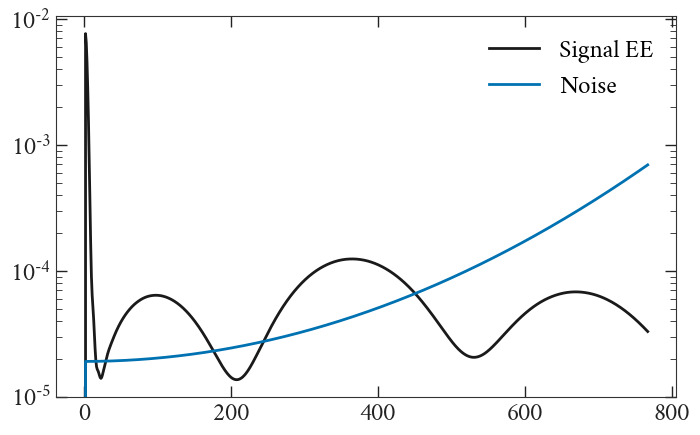

PyObject <matplotlib.legend.Legend object at 0x2b28f0912910>

In [153]:
plt.figure()
plot(theory.clee, "-", label="Signal EE")
plot(noise.nlee, "-", label="Noise")
yscale("log")
legend()

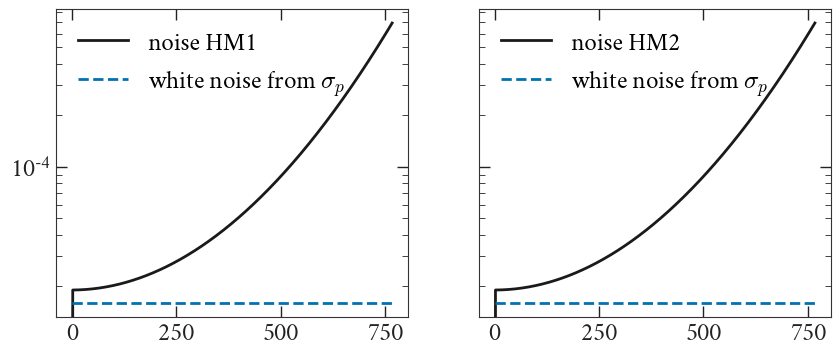

PyObject <matplotlib.legend.Legend object at 0x2b291d3549d0>

In [154]:
N_ℓ_1 = sum(mask1.^2 .* (var_map) .* Ω_p) / sum(mask1.^2)
N_ℓ_2 = sum(mask2.^2 .* (var_map) .* Ω_p) / sum(mask2.^2)

N_ℓ_1_hat = SpectralVector(ones(3nside)) .*  N_ℓ_1 
N_ℓ_2_hat = SpectralVector(ones(3nside)) .*  N_ℓ_2

factor_11 = SpectralVector((noise.nlee ./ N_ℓ_1_hat.parent))
factor_22 = SpectralVector((noise.nlee ./ N_ℓ_2_hat.parent));

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=true, sharex=true)

axes[1].plot(noise.nlee, "-", label="noise HM1" )
axes[1].plot(N_ℓ_1_hat.parent, "--", label=raw"white noise from $\sigma_p$")
axes[1].set_yscale("log")

axes[2].plot(noise.nlee, "-", label="noise HM2" )
axes[2].plot(N_ℓ_2_hat.parent, "--", label=raw"white noise from $\sigma_p$")
# axes[2].set_xlim(0,200)
axes[2].set_yscale("log")

axes[1].legend()
axes[2].legend()

In [155]:
import AngularPowerSpectra: EE, PP, QQ, UU, ∅∅

identity_spectrum = SpectralVector(ones(3nside))
r_coeff = Dict{AngularPowerSpectra.VIndex, SpectralVector{Float64, Vector{Float64}}}(
    (EE, "$(freq1)_hm1", "$(freq1)_hm1") => sqrt.(factor_11),
    (EE, "$(freq1)_hm1", "$(freq2)_hm2") => identity_spectrum,
    (EE, "$(freq2)_hm2", "$(freq1)_hm1") => identity_spectrum,
    (EE, "$(freq2)_hm2", "$(freq2)_hm2") => sqrt.(factor_22)
);

In [156]:
import AngularPowerSpectra: EE, PP, QQ, UU

clee = SpectralVector(convert(Vector{Float64},theory.clee))
nlee = SpectralVector(convert(Vector{Float64},noise.nlee))

spectra = Dict{AngularPowerSpectra.VIndex, SpectralVector{Float64, Array{Float64,1}}}(
    (EE, "$(freq1)_hm1", "$(freq1)_hm1") => clee,
    (EE, "$(freq1)_hm1", "$(freq2)_hm2") => clee,
    (EE, "$(freq2)_hm2", "$(freq1)_hm1") => clee,
    (EE, "$(freq2)_hm2", "$(freq2)_hm2") => clee
)

factorized_mcm = lu(mcm_12.parent);
@time C = AngularPowerSpectra.compute_coupled_covmat_EE(workspace, spectra, r_coeff,
                         m_143_hm1, m_143_hm2, m_143_hm1, m_143_hm2);
# C = inv(mcm_12.parent) * C.parent * inv(mcm_12.parent');

  4.236268 seconds (11.89 k allocations: 350.194 MiB, 1.20% gc time)


In [157]:
# nmt_ells = collect(0:3nside-1)  # Array of multipoles
# b = nmt.NmtBin(nside=nside, bpws=nmt_ells, ells=nmt_ells, weights=ones(size(nmt_ells)))
# f2_1 = nmt.NmtField(mask1.pixels, [flat_mask.pixels, flat_mask.pixels])
# f2_2 = nmt.NmtField(mask2.pixels, [flat_mask.pixels, flat_mask.pixels])

# w22 = nmt.NmtWorkspace()
# w22.compute_coupling_matrix(f2_1, f2_2, b)
# nmt_mcm = w22.get_coupling_matrix()[1:4:4*lmax, 1:4:4*lmax];

In [158]:

f2_1 = nmt.NmtField(mask1.pixels, [flat_mask.pixels, flat_mask.pixels])
f2_2 = nmt.NmtField(mask2.pixels, [flat_mask.pixels, flat_mask.pixels])
b = nmt.NmtBin.from_nside_linear(nside, 1)
w22 = nmt.NmtWorkspace()
w22.compute_coupling_matrix(f2_1, f2_2, b)
cw = nmt.NmtCovarianceWorkspace()
cw.compute_coupling_coefficients(f2_1, f2_2, f2_1, f2_2)

cl_ee = theory.clee
cl_eb = zeros(length(theory.clee))
cl_bb = zeros(length(theory.clee))
@time covar_22_22 = nmt.gaussian_covariance(cw, 2, 2, 2, 2,  # Spins of the 4 fields
                                      [cl_ee .+ noise.nlee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee .+ noise.nlee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      w22, wb=w22, coupled=true)
np = pyimport("numpy")
cov = np.reshape(covar_22_22, (lmax, 4, lmax, 4))
covar_EE_EE = cov[:, 1, :, 1];

  0.278672 seconds (1.72 k allocations: 72.045 MiB)


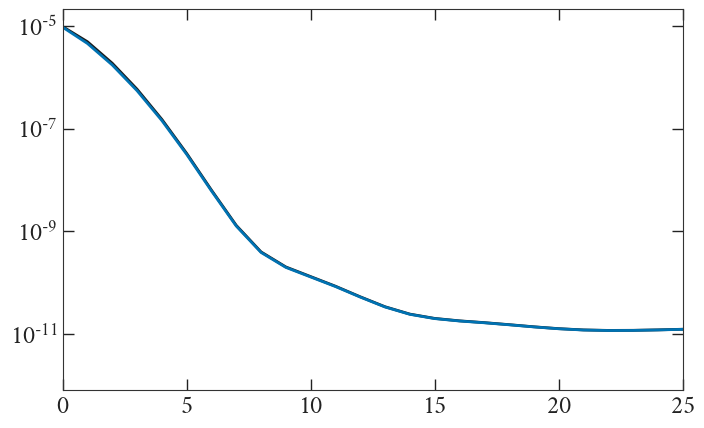

In [167]:
plt.plot(diag(C.parent)[3:end], "-")
plt.plot(diag(covar_EE_EE)[3:end], "-")
plt.xlim(0,25)
yscale("log")

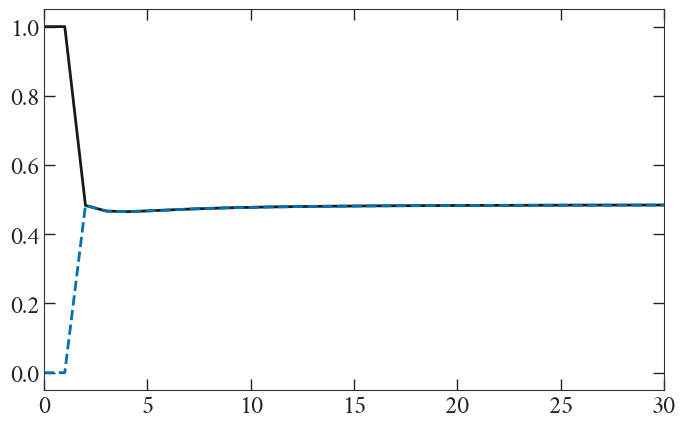

(0.0, 30.0)

In [160]:
plt.plot(diag(mcm_12.parent), "-")
plt.plot(diag(nmt_mcm), "--")
# plt.plot(mcm_12.parent)
plt.xlim(0,30)

In [161]:
ells = collect(0:3nside-1);

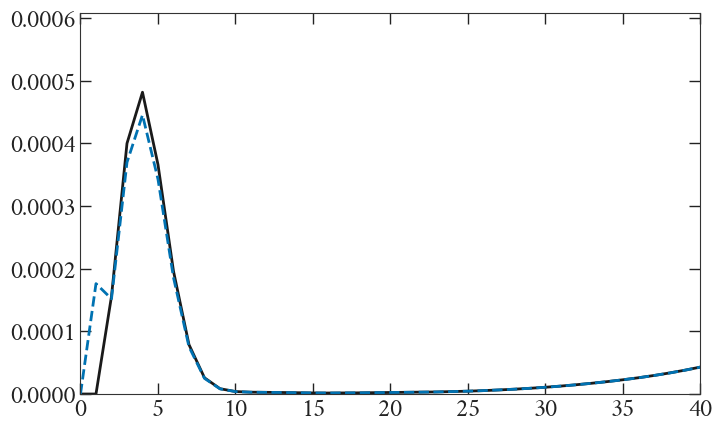

(0.0, 40.0)

In [162]:
plt.plot((diag(C.parent) .* ells.^4) , "-")
plt.plot((diag(covar_EE_EE)  .* ells.^4), "--")
# plt.xlim(0,29)

plt.ylim(0, ((C.parent[70,70]) * 70^4))
plt.xlim(0, 40)
# yscale("log")

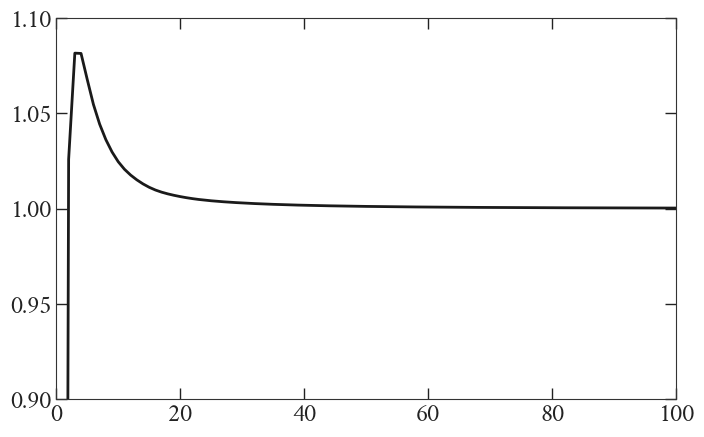

(0.9, 1.1)

In [168]:
plt.plot(diag(C.parent) ./ diag(covar_EE_EE)[1:end] , "-")
plt.xlim(0,100)
plt.axhline(eps() * 1000)
plt.ylim(0.9,1.1)